# Import des bibliothèques


In [1]:
import pandas as pd
import re 
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
%matplotlib inline
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


# Chargement des données

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Copy of original data 

So that even if we make any changes in these datasets we would not lose the original datasets

In [3]:
train_copy = train.copy()
test_copy = test.copy()

# Data Exploration

In [51]:
print('Shape of train data :' , train_copy.shape)
print('Shape of test data :'  ,test_copy.shape)

Shape of train data : (6525, 3)
Shape of test data : (2610, 2)


In [52]:
print('Columns of train data :' ,train_copy.columns)
print('Columns of test data :' , test_copy.columns)

Columns of train data : Index(['TweetId', 'Label', 'TweetText'], dtype='object')
Columns of test data : Index(['TweetId', 'TweetText'], dtype='object')


In [53]:
train_copy.dtypes


TweetId       int64
Label        object
TweetText    object
dtype: object

In [54]:
test_copy.dtypes

TweetId       int64
TweetText    object
dtype: object

In [55]:
train_copy.info

<bound method DataFrame.info of                  TweetId     Label  \
0     304271250237304833  Politics   
1     304834304222064640  Politics   
2     303568995880144898    Sports   
3     304366580664528896    Sports   
4     296770931098009601    Sports   
...                  ...       ...   
6520  296675082267410433  Politics   
6521  306677536195231746    Sports   
6522  306451295307431937    Sports   
6523  306088574221176832    Sports   
6524  277090953242759169  Politics   

                                              TweetText  
0     '#SecKerry: The value of the @StateDept and @U...  
1                               '@rraina1481 I fear so'  
2     'Watch video highlights of the #wwc13 final be...  
3     'RT @chelscanlan: At Nitro Circus at #AlbertPa...  
4     '@cricketfox Always a good thing. Thanks for t...  
...                                                 ...  
6520  'Photo: PM has laid a wreath at Martyrs Monume...  
6521  'The secret of the Chennai pitch - crumbl

In [56]:
train_copy.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


In [57]:
print('The percentage  of lines that contains non-missing values in the train dataset is: ', (len(train_copy.notnull())/len(train_copy))*100)

The percentage  of lines that contains non-missing values in the train dataset is:  100.0


In [58]:
print('The percentage  of lines that contains non-missing values in the train dataset is: ', (len(test_copy.notnull())/len(test_copy))*100)

The percentage  of lines that contains non-missing values in the train dataset is:  100.0


In [59]:
test_copy.head()

,TweetId,TweetText
0,306486520121012224,'28. The home side threaten again through Maso...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....
2,289531046037438464,'@Sochi2014 construction along the shores of t...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...


In [60]:
train_copy['Label'].value_counts()

Label
Sports      3325
Politics    3200
Name: count, dtype: int64

# Data Visualization

Label pourcentage
             Label  Pourcentage
Label                          
Sports      Sports     0.509579
Politics  Politics     0.490421


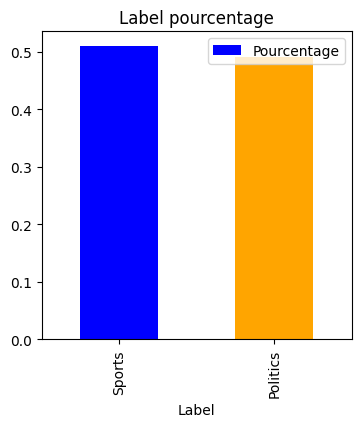

In [61]:
data={"Label" :train_copy["Label"].value_counts(normalize=True).index ,'Pourcentage' :train_copy["Label"].value_counts(normalize=True) }
data=pd.DataFrame(data)
print('Label pourcentage')
print(data)
color = ['blue','orange']
data.plot.bar(title='Label pourcentage', x="Label", y='Pourcentage',color=color ,figsize=(4,4) )
plt.show()

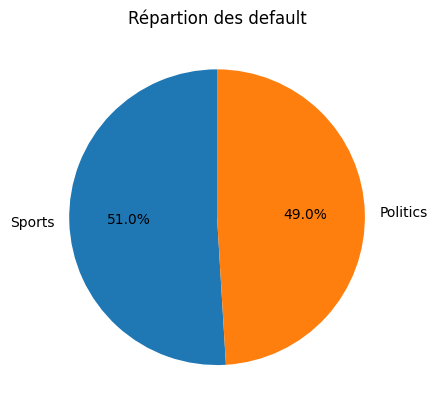

In [62]:

plt.pie(data['Pourcentage'],labels=data['Label'],autopct='%1.1f%%',startangle=90)
plt.title('Répartion des default')
plt.show()

#  Feature Extraction


This extraction step involves converting raw text data into numerical features that can be fed into machine learning models. In this task, we used the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer to transform the text data into numerical features. TF-IDF vectorizer helps in capturing the importance of a word in a document relative to the entire corpus.

In [4]:
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    return ' '.join(lemmatized_tokens)

In [7]:
train_copy['cleaned_tweets']=train_copy['TweetText'].apply(preprocess_text)
train_copy['cleaned_tweets'] = train_copy['cleaned_tweets'].apply(lemmatize_text)
train_copy['cleaned_tweets']

0       seckerry the value of the and be measure not i...
1                                               i fear so
2       watch video highlight of the wwc final between...
3       rt at nitro circus at albertpark theymakeitloo...
4             always a good thing thanks for the feedback
                              ...                        
6520    photo pm have laid a wreath at martyr monument...
6521    the secret of the chennai pitch crumble on the...
6522                            he isnt on twitter either
6523    which england player would you take out to din...
6524    dmitry medvedev express condolence to the fami...
Name: cleaned_tweets, Length: 6525, dtype: object

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_copy['cleaned_tweets'], train_copy['Label'], test_size=0.2, random_state=42)


In [9]:
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = vectorizer.transform(X_test)


# Model Training

In the Model training step we used the extracted features to train various machine learning models. In this task, we trained multiple models including Logistic Regression, Random Forest, Naive Bayes, Support Vector Classifier, XGBoost, and a TensorFlow neural network.

In [101]:

# Logistic Regression
lr_model = LogisticRegression(C=10, solver='liblinear')
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Naive Bayes
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# Support Vector Classifier
svc_model = SVC(C=1.0, kernel='linear')
svc_model.fit(X_train_tfidf, y_train)
y_pred_svc = svc_model.predict(X_test_tfidf)
print("Support Vector Classifier Accuracy:", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
xgb_model.fit(X_train_tfidf, y_train_encoded)
y_pred_xgb = label_encoder.inverse_transform(xgb_model.predict(X_test_tfidf))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# TensorFlow Neural Network
model = Sequential()
model.add(Dense(512, input_dim=X_train_tfidf.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' if you have more than two classes

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Use 'categorical_crossentropy' for multi-class

# Convert labels to a format compatible with TensorFlow
y_train_tf = (y_train == 'Politics').astype(int)
y_test_tf = (y_test == 'Politics').astype(int)

# Train the model
model.fit(X_train_tfidf.toarray(), y_train_tf, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

# Evaluate the model
y_pred_tf = (model.predict(X_test_tfidf.toarray()) > 0.5).astype(int)
print("TensorFlow Neural Network Accuracy:", accuracy_score(y_test_tf, y_pred_tf))
print(classification_report(y_test_tf, y_pred_tf))


Logistic Regression Accuracy: 0.9440613026819923
              precision    recall  f1-score   support

    Politics       0.95      0.94      0.94       638
      Sports       0.94      0.95      0.95       667

    accuracy                           0.94      1305
   macro avg       0.94      0.94      0.94      1305
weighted avg       0.94      0.94      0.94      1305

Random Forest Accuracy: 0.8659003831417624
              precision    recall  f1-score   support

    Politics       0.91      0.81      0.85       638
      Sports       0.83      0.92      0.88       667

    accuracy                           0.87      1305
   macro avg       0.87      0.86      0.87      1305
weighted avg       0.87      0.87      0.87      1305

Naive Bayes Accuracy: 0.9325670498084291
              precision    recall  f1-score   support

    Politics       0.95      0.91      0.93       638
      Sports       0.92      0.95      0.94       667

    accuracy                           0.93      

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.6666 - loss: 0.6020 - val_accuracy: 0.9195 - val_loss: 0.1679
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9670 - loss: 0.0944 - val_accuracy: 0.9291 - val_loss: 0.1622
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9881 - loss: 0.0342 - val_accuracy: 0.9253 - val_loss: 0.1711
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.9934 - loss: 0.0174 - val_accuracy: 0.9310 - val_loss: 0.1784
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9929 - loss: 0.0153 - val_accuracy: 0.9330 - val_loss: 0.1841
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9962 - loss: 0.0100 - val_accuracy: 0.9330 - val_loss: 0.1842
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9961 - loss: 0.0076 - val_accuracy: 0.9330 - val_loss: 0.1882
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9968 - loss: 0.0082 - val_accuracy: 0.9368 -

# Hyper-parameter Tuning

Hyper-parameter tuning involves finding the best set of parameters for each model to optimize their performance. This can be done using techniques like Grid Search or Random Search. Below, we show how to perform hyper-parameter tuning for each model using Grid Search.

In [99]:
param_grids = {
    'LogisticRegression': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']},
    'RandomForestClassifier': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'XGBClassifier': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'MultinomialNB': {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
}

# Define models
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'SVC': SVC(),
    'MultinomialNB': MultinomialNB()
}



In [ ]:
best_params = {}
y_train_par =y_train
for model_name in models.keys():
    if model_name=='XGBClassifier' :
        label_encoder = LabelEncoder()
        y_train_par = label_encoder.fit_transform(y_train)

    grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_tfidf, y_train_par)
    best_params[model_name] = grid_search.best_params_
    print(f"Best parameters for {model_name}: {best_params[model_name]}")

# Performance

The performance of the models is evaluated using metrics such as accuracy, precision, recall, and F1-score. The performance is broken down into two stages: model training using the resulted parameter of hyper-parameter tuning, then the second step is output prediction.

In [86]:
#Naive Bayes classifier

classifier = MultinomialNB(**{'alpha': 0.1})
classifier.fit(X_train_tfidf, y_train)

y_pred = classifier.predict(X_test_tfidf)


print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))



Accuracy: 0.946360153256705
              precision    recall  f1-score   support

    Politics       0.95      0.94      0.95       638
      Sports       0.95      0.95      0.95       667

    accuracy                           0.95      1305
   macro avg       0.95      0.95      0.95      1305
weighted avg       0.95      0.95      0.95      1305



In [73]:
# LogisticRegression
lr_model = LogisticRegression(**{'C': 10, 'solver': 'liblinear'})
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9440613026819923
              precision    recall  f1-score   support

    Politics       0.95      0.94      0.94       638
      Sports       0.94      0.95      0.95       667

    accuracy                           0.94      1305
   macro avg       0.94      0.94      0.94      1305
weighted avg       0.94      0.94      0.94      1305



In [74]:
# Random Forest
rf_model = RandomForestClassifier(**{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200})
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9057471264367816
              precision    recall  f1-score   support

    Politics       0.92      0.89      0.90       638
      Sports       0.90      0.92      0.91       667

    accuracy                           0.91      1305
   macro avg       0.91      0.91      0.91      1305
weighted avg       0.91      0.91      0.91      1305



In [98]:
# XGBoost
xgb_model = XGBClassifier(**{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300})
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
xgb_model.fit(X_train_tfidf, y_train_encoded)
y_pred_encoded = xgb_model.predict(X_test_tfidf)
y_pred_xgb = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.8996168582375479
              precision    recall  f1-score   support

    Politics       0.92      0.87      0.89       638
      Sports       0.88      0.93      0.90       667

    accuracy                           0.90      1305
   macro avg       0.90      0.90      0.90      1305
weighted avg       0.90      0.90      0.90      1305



In [92]:
#  SVC model
svc_model = SVC(**{'C': 1, 'kernel': 'linear'})  # You can change the kernel type if needed
svc_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_svc = svc_model.predict(X_test_tfidf)

# Print accuracy and classification report
print("SVC Accuracy:", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

SVC Accuracy: 0.9356321839080459
              precision    recall  f1-score   support

    Politics       0.94      0.92      0.93       638
      Sports       0.93      0.95      0.94       667

    accuracy                           0.94      1305
   macro avg       0.94      0.94      0.94      1305
weighted avg       0.94      0.94      0.94      1305



In [10]:
# TensorFlow Neural Network
model = Sequential()
model.add(Dense(512, input_dim=X_train_tfidf.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' if you have more than two classes

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Use 'categorical_crossentropy' for multi-class

# Convert labels to a format compatible with TensorFlow
y_train_tf = (y_train == 'Politics').astype(int)
y_test_tf = (y_test == 'Politics').astype(int)

model.fit(X_train_tfidf.toarray(), y_train_tf, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

# Evaluate the model
y_pred_tf = (model.predict(X_test_tfidf.toarray()) > 0.5).astype(int)

# Convert predictions back to original labels
y_pred_original = np.where(y_pred_tf == 1, 'Politics', 'Sports')

# Calculate accuracy and other metrics
print("TensorFlow Neural Network Accuracy:", accuracy_score(y_test, y_pred_original))
print(classification_report(y_test, y_pred_original))

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.7235 - loss: 0.5944 - val_accuracy: 0.9291 - val_loss: 0.1598
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9608 - loss: 0.1012 - val_accuracy: 0.9310 - val_loss: 0.1483
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9928 - loss: 0.0308 - val_accuracy: 0.9349 - val_loss: 0.1556
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9925 - loss: 0.0196 - val_accuracy: 0.9330 - val_loss: 0.1737
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9951 - loss: 0.0117 - val_accuracy: 0.9310 - val_loss: 0.1788
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9976 - loss: 0.0080 - val_accuracy: 0.9387 - val_loss: 0.1772
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9960 - loss: 0.0088 - val_accuracy: 0.9368 - val_loss: 0.1822
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9962 - loss: 0.0085 - val_accuracy: 0.9310 - 

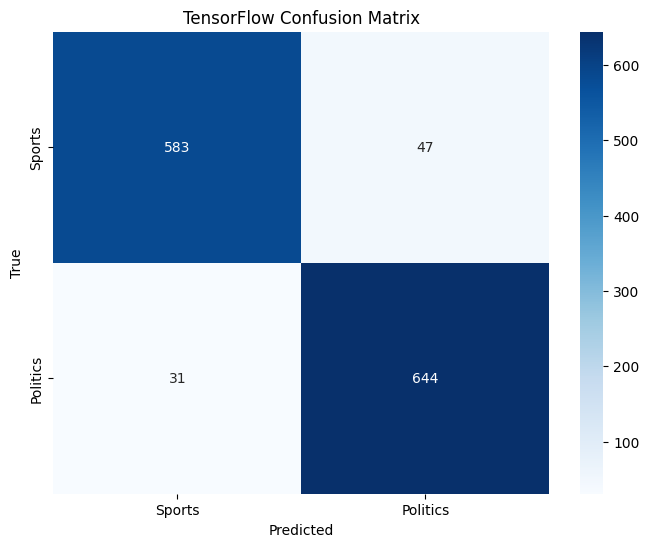

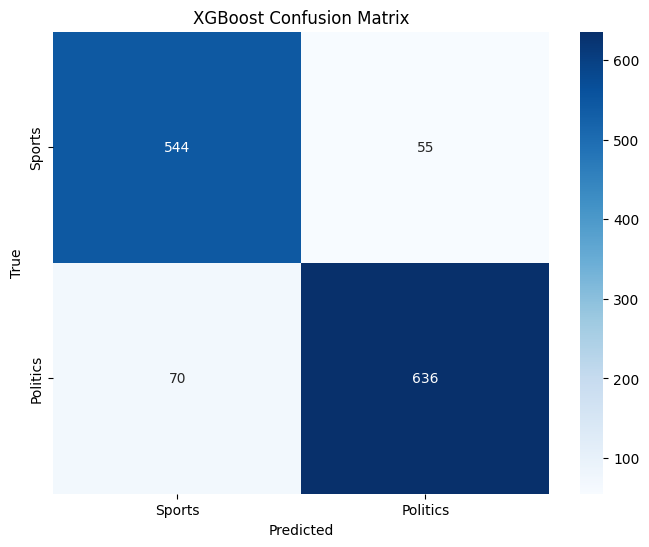

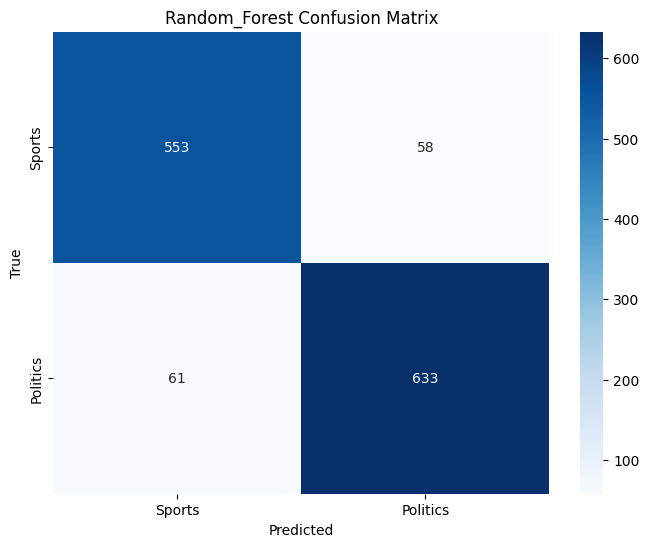

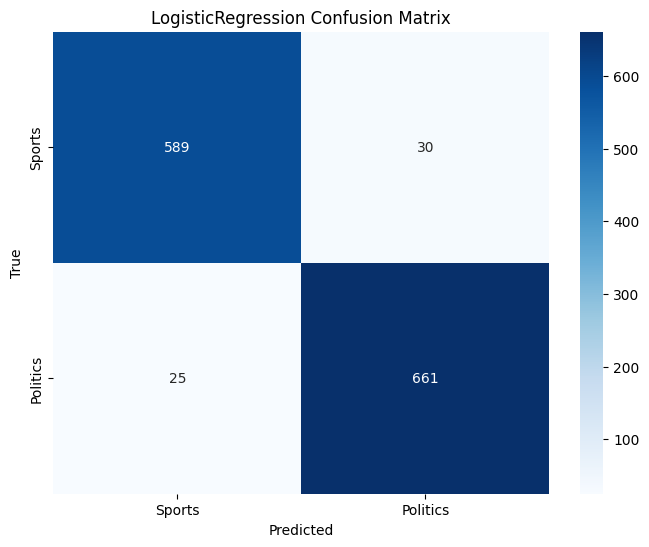

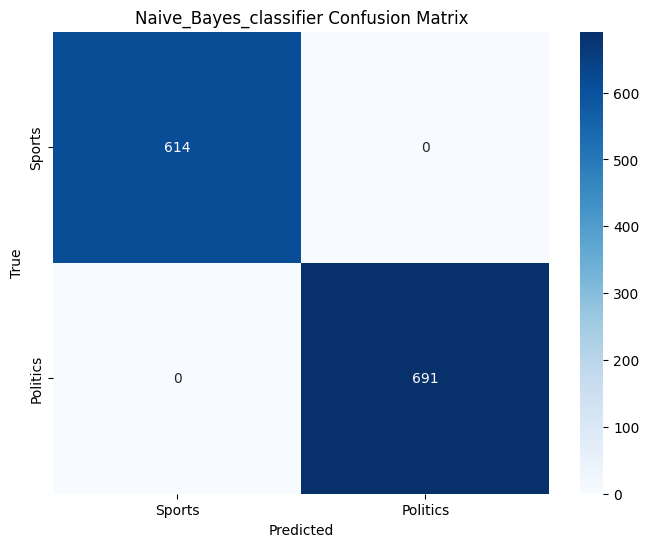

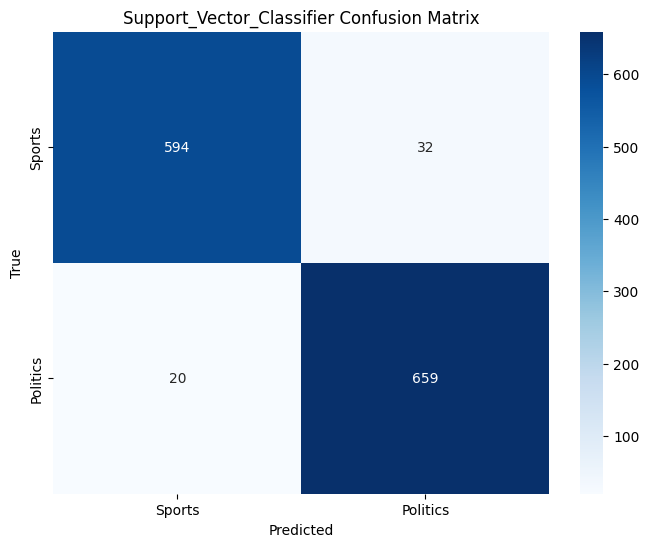

In [37]:

valeur_predis=[y_pred_original,y_pred_xgb, y_pred_rf, y_pred_lr, y_pred, y_pred_svc]
model=['TensorFlow','XGBoost','Random_Forest','LogisticRegression','Naive_Bayes_classifier', 'Support_Vector_Classifier']
for i  in range(len(valeur_predis)) :
    cm = confusion_matrix(valeur_predis[i], y_pred)

    # Define labels for the confusion matrix
    labels = ['Sports', 'Politics']

    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model[i] + ' Confusion Matrix')
    plt.show()

# Future Improvements

### To further enhance the performance of the models and the overall solution, consider the following improvements:

1- Feature Engineering:

N-grams: Incorporate bi-grams or tri-grams in your TfidfVectorizer to capture more context in the text data.

Domain-specific Features: Add features that are specific to the domain of your dataset, such as named entity recognition (NER) tags, sentiment scores, or part-of-speech tags.

Word Embeddings: Use word embeddings (e.g., Word2Vec, GloVe, FastText) or contextual embeddings (e.g., BERT, ELMo) to capture semantic relationships between words.

2- Model Complexity:

Ensemble Methods: Explore ensemble techniques like stacking, blending, or bagging to combine predictions from multiple models, which can lead to better generalization.

Deep Learning Models: Experiment with more complex neural network architectures, such as convolutional neural networks (CNNs) or recurrent neural networks (RNNs) for text classification tasks.

3- Hyper-parameter Optimization:

Automated Hyper-parameter Tuning: Use automated hyper-parameter tuning libraries like Optuna or Hyperopt to find the optimal hyper-parameters more efficiently.

4-Data Augmentation:

Synthetic Data Generation: Use techniques like data augmentation or synthetic data generation to increase the size and diversity of your training dataset.

In [12]:
test_copy['cleaned_tweets']=test_copy['TweetText'].apply(preprocess_text)
test_copy['cleaned_tweets'] = test_copy['cleaned_tweets'].apply(lemmatize_text)


X_test_tfidf = vectorizer.transform(test_copy['cleaned_tweets'])

# Evaluate the model
y_pred_tf = (model.predict(X_test_tfidf.toarray()) > 0.5).astype(int)

# Convert predictions back to original labels
y_pred_original = np.where(y_pred_tf == 1, 'Politics', 'Sports')




82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [13]:
test_copy['Label']=y_pred_original
test_copy.drop(['cleaned_tweets'] ,axis=1, inplace=True)
test_copy

,TweetId,TweetText,Label
0,306486520121012224,'28. The home side threaten again through Maso...,Sports
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....,Politics
2,289531046037438464,'@Sochi2014 construction along the shores of t...,Politics
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...,Politics
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...,Sports
...,...,...,...
2605,282023761044189184,'Qualifier 1 and Eliminator games will be play...,Sports
2606,303879735006601216,"@reesedward Hi Edward, it's not a #peacekeepin...",Sports
2607,297956846046703616,'Perera was @SunRisersIPL first #IPL purchase ...,Sports
2608,304265049537658880,"'#SecKerry: Thanks to Senator @TimKaine, @RepR...",Politics


In [14]:
# Transforming DataFrame into a CSV file
test_copy.to_csv('results.csv', index=False)